In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import gzip
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100, "display.width",200, "display.max_colwidth",40)
import pickle
from termcolor import colored

import torch
torch.set_printoptions(linewidth=120)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tudata
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

import pytorch_lightning as pl
import pytorch_lightning.callbacks as plc

from binary_label_metrics import BinaryLabelMetrics

for x in [("numpy","np"),("pandas","pd"),("torch","torch"),("pytorch_lightning","pl")]:
  print(f"{x[0]} {eval(f'{x[1]}.__version__')}")

numpy 1.22.1
pandas 1.3.5
torch 1.9.1
pytorch_lightning 1.6.4


Data Prep

In [3]:
human_hrh3 = "".join('merappdgpl nasgalagea aaaggargfs aawtavlaal mallivatvl gnalvmlafv adsslrtqnn ffllnlaisd flvgafcipl yvpyvltgrw tfgrglcklw lvvdyllcts safnivlisy drflsvtrav syraqqgdtr ravrkmllvw vlafllygpa ilsweylsgg ssipeghcya effynwyfli tastlefftp flsvtffnls iylniqrrtr lrldgareaa gpepppeaqp spppppgcwg cwqkghgeam plhrygvgea avgaeageat lgggggggsv asptsssgss srgterprsl krgskpsass aslekrmkmv sqsftqrfrl srdrkvaksl avivsifglc wapytllmii raachghcvp dywyetsfwl lwansavnpv lyplchhsfr raftkllcpq klkiqphssl ehcwk'.split()).upper()
human_acm1 = "".join('mntsappavs pnitvlapgk gpwqvafigi ttgllslatv tgnllvlisf kvntelktvn nyfllslaca dliigtfsmn lyttyllmgh walgtlacdl wlaldyvasn asvmnlllis fdryfsvtrp lsyrakrtpr raalmiglaw lvsfvlwapa ilfwqylvge rtvlagqcyi qflsqpiitf gtamaafylp vtvmctlywr iyretenrar elaalqgset pgkgggssss sersqpgaeg spetppgrcc rccraprllq ayswkeeeee degsmeslts segeepgsev vikmpmvdpe aqaptkqppr sspntvkrpt kkgrdragkg qkprgkeqla krktfslvke kkaartlsai llafiltwtp ynimvlvstf ckdcvpetlw elgywlcyvn stinpmcyal cnkafrdtfr llllcrwdkr rwrkipkrpg svhrtpsrqc'.split()).upper()
human_5ht6r = "".join('mvpepgptan stpawgagpp sapggsgwva aalcvvialt aaansllial ictqpalrnt snfflvslft sdlmvglvvm ppamlnalyg rwvlarglcl lwtafdvmcc sasilnlcli sldryllils plryklrmtp lralalvlga wslaalasfl plllgwhelg harppvpgqc rllaslpfvl vasgltfflp sgaicftycr illaarkqav qvaslttgma sqasetlqvp rtprpgvesa dsrrlatkhs rkalkasltl gillgmffvt wlpffvaniv qavcdcispg lfdvltwlgy cnstmnpiiy plfmrdfkra lgrflpcprc prerqaslas pslrtshsgp rpglslqqvl plplppdsds dsdagsggss glrltaqlll pgeatqdppl ptraaaavnf fnidpaepel rphplgiptn'.split()).upper()
human_5ht2c = "".join('mvnlrnavhs flvhligllv wqsdisvspv aaivtdifnt sdggrfkfpd gvqnwpalsi viiiimtigg nilvimavsm ekklhnatny flmslaiadm lvgllvmpls llailydyvw plprylcpvw isldvlfsta simhlcaisl dryvairnpi ehsrfnsrtk aimkiaivwa isigvsvpip viglrdeekv fvnnttcvln dpnfvligsf vaffipltim vitycltiyv lrrqalmllh ghteeppgls ldflkcckrn taeeensanp nqdqnarrrk kkerrprgtm qainnerkas kvlgivffvf limwcpffit nilsvlceks cnqklmekll nvfvwigyvc sginplvytl fnkiyrrafs nylrcnykve kkppvrqipr vaatalsgre lnvniyrhtn epviekasdn epgiemqven lelpvnpssv vserissv'.split()).upper()
human_5ht2a = "".join('mdilceents lssttnslmq lnddtrlysn dfnsgeants dafnwtvdse nrtnlscegc lspsclsllh lqeknwsall tavviiltia gnilvimavs lekklqnatn yflmslaiad mllgflvmpv smltilygyr wplpsklcav wiyldvlfst asimhlcais ldryvaiqnp ihhsrfnsrt kaflkiiavw tisvgismpi pvfglqddsk vfkegsclla ddnfvligsf vsffipltim vityfltiks lqkeatlcvs dlgtraklas fsflpqssls seklfqrsih repgsytgrr tmqsisneqk ackvlgivff lfvvmwcpff itnimavick escnedviga llnvfvwigy lssavnplvy tlfnktyrsa fsryiqcqyk enkkplqlil vntipalayk ssqlqmgqkk nskqdakttd ndcsmvalgk qhseeaskdn sdgvnekvsc v'.split()).upper()
human_drd3 = "".join('maslsqlsgh lnytcgaens tgasqarpha yyalsycali laivfgnglv cmavlkeral qtttnylvvs lavadllvat lvmpwvvyle vtggvwnfsr iccdvfvtld vmmctasiln lcaisidryt avvmpvhyqh gtgqsscrrv almitavwvl afavscpllf gfnttgdptv csisnpdfvi yssvvsfylp fgvtvlvyar iyvvlkqrrr kriltrqnsq cnsvrpgfpq qtlspdpahl elkryysicq dtalggpgfq erggelkree ktrnslspti apklslevrk lsngrlstsl klgplqprgv plrekkatqm vaivlgafiv cwlpfflthv lnthcqtchv spelysattw lgyvnsalnp viyttfnief rkaflkilsc'.split()).upper()
human_5ht1a = "".join('mdvlspgqgn nttsppapfe tggnttgisd vtvsyqvits lllgtlifca vlgnacvvaa ialerslqnv anyligslav tdlmvsvlvl pmaalyqvln kwtlgqvtcd lfialdvlcc tssilhlcai aldrywaitd pidyvnkrtp rraaalislt wligflisip pmlgwrtped rsdpdactis kdhgytiyst fgafyiplll mlvlygrifr aarfrirktv kkvektgadt rhgaspapqp kksvngesgs rnwrlgvesk aggalcanga vrqgddgaal evievhrvgn skehlplpse agptpcapas ferknernae akrkmalare rktvktlgii mgtfilcwlp ffivalvlpf cesschmptl lgaiinwlgy snsllnpviy ayfnkdfqna fkkiikckfc rq'.split()).upper()

receptors = {'human_hrh3':human_hrh3,'human_acm1':human_acm1,'human_5ht6r':human_5ht6r,'human_5ht2c':human_5ht2c,'human_5ht2a':human_5ht2a,'human_drd3':human_drd3,'human_5ht1a':human_5ht1a}
data_df = pd.read_csv('aminergic_data/all.csv')

In [4]:
data_df.tail()

,Smiles,hrh3_human,acm1_human,5ht6r_human,5ht2c_human,5ht2a_human,drd3_human,5ht1a_human
58734,CN1CCN(c2nc(N)nc3cc(-c4ccco4)ccc23)CC1,0.0,NaN,NaN,NaN,NaN,NaN,NaN
58735,Cc1ccc(C(=O)Nc2ccc([C@H]3CCC(N4CCC[C...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
58736,CC(O)COc1ccc2c(c1)CCC1(CCN(C3CCC3)CC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58737,Nc1ccc(S(=O)(=O)NCCCCc2c[nH]cn2)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58738,COc1ccccc1-c1ccc(CN(CC(=O)C(C)(C)O)C...,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
receptor_ligand_pairs = []
cols = list(data_df.columns)
for i in range(len(data_df)):
    ligand_seq = data_df.iloc[i]['Smiles']
    for c in cols[1:]:
        try:
            val = int(data_df.iloc[i][c])
            c_mod = 'human_'+c[:-6]
            receptor_seq = receptors[c_mod]
            if len(receptor_seq)>10 and len(ligand_seq)>10 and len(ligand_seq)<100:
                receptor_ligand_pairs.append([receptor_seq,ligand_seq,val])
        except:
            pass

print(len(receptor_ligand_pairs))

39627


In [6]:
model_df = pd.DataFrame(receptor_ligand_pairs,columns=['receptor_seq','ligand_seq','response'])
print(f"model df has dimensions {len(model_df)} x {len(list(model_df.columns))}")

model df has dimensions 39627 x 3


In [7]:
amino2ind = dict((k,v) for v,k in enumerate("ACDEFGHIKLMNPQRSTVWY",1)) #0 for null
smi2ind = dict((k,v) for v,k in enumerate(''.join(set(list(''.join(model_df['ligand_seq'].tolist())))),1)) #0 for null

model_df[["receptor_ind"]] = model_df[["receptor_seq"]].applymap(lambda x:[amino2ind[l] for l in x])
model_df[["ligand_ind"]] = model_df[["ligand_seq"]].applymap(lambda x:[smi2ind[l] for l in x])
model_df[["receptor_sz","ligand_sz"]] = model_df[["receptor_seq","ligand_seq"]].applymap(len)

In [8]:
model_df.sample(5)

,receptor_seq,ligand_seq,response,receptor_ind,ligand_ind,receptor_sz,ligand_sz
17130,MVNLRNAVHSFLVHLIGLLVWQSDISVSPVAAIVTD...,COc1ccccc1N1CCN(CC2CC(=O)c3ccccc32)CC1,0,"[11, 18, 12, 10, 15, 12, 1, 18, 7, 1...","[6, 9, 37, 32, 37, 37, 37, 37, 37, 3...",458,38
31023,MASLSQLSGHLNYTCGAENSTGASQARPHAYYALSY...,COc1cc(C)ccc1N1CCN(CCCCOc2ccc3c(c2)N...,0,"[11, 1, 16, 10, 16, 14, 10, 16, 6, 7...","[6, 9, 37, 32, 37, 37, 28, 6, 11, 37...",400,48
10410,MDILCEENTSLSSTTNSLMQLNDDTRLYSNDFNSGE...,Cc1c(Cl)ccc2c1N1[C@H](C)CNC[C@H]1C2,0,"[11, 3, 8, 10, 2, 4, 4, 12, 17, 16, ...","[6, 37, 32, 37, 28, 6, 15, 11, 37, 3...",471,35
28479,MASLSQLSGHLNYTCGAENSTGASQARPHAYYALSY...,O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1...,0,"[11, 1, 16, 10, 16, 14, 10, 16, 6, 7...","[9, 27, 6, 28, 34, 6, 6, 6, 6, 34, 3...",400,47
13715,MVNLRNAVHSFLVHLIGLLVWQSDISVSPVAAIVTD...,Fc1cccc(N2CC[C@H]3CNC[C@H]32)c1,0,"[11, 18, 12, 10, 15, 12, 1, 18, 7, 1...","[38, 37, 32, 37, 37, 37, 37, 28, 34,...",458,31


In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(model_df, test_size=0.2)
test_df, valid_df = train_test_split(test_df, test_size=0.25)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"train sz: {len(train_df)}, test sz: {len(test_df)}, valid sz: {len(valid_df)}")

train sz: 31701, test sz: 5944, valid sz: 1982


PyTorch Ligtning Data Loader

In [10]:
class PandasDataset(tudata.Dataset):
  
  def __init__(self, df):
    super().__init__()
    self.df = df
  
  def __len__(self):
    return self.df.shape[0]
  
  def __getitem__(self, idx):
    return self.df.iloc[idx]


def pad_collate(batch):
  return \
      (pad_sequence([torch.LongTensor(x["receptor_ind"]) for x in batch],batch_first=True,padding_value=0), \
      torch.LongTensor([x["receptor_sz"] for x in batch]), \
      pad_sequence([torch.LongTensor(x["ligand_ind"]) for x in batch],batch_first=True,padding_value=0), \
      torch.LongTensor([x["ligand_sz"] for x in batch])), \
      torch.FloatTensor([x["response"] for x in batch])

# #test
# dl = tudata.DataLoader(PandasDataset(train_df), 
#                         batch_size=2, num_workers=1, drop_last=False, shuffle=True, collate_fn=pad_collate)
# dl = iter(dl)
# for n in range(2):
#   print(colored(f"==batch {n+1}==",attrs=["bold"]))
#   dl.next(); print()
# del dl

In [11]:
train_df.shape

(31701, 7)

In [12]:
class PandasDataModule(pl.LightningDataModule):
  
  def __init__(self, prm):
    super().__init__()
    self.bs = prm["batch_size"]
  
  def train_dataloader(self):
    return tudata.DataLoader(PandasDataset(train_df), batch_size=self.bs, num_workers=8, drop_last=False, shuffle=True, collate_fn=pad_collate)
  
  def val_dataloader(self):
    return tudata.DataLoader(PandasDataset(valid_df), batch_size=self.bs, num_workers=8, drop_last=False, shuffle=False, collate_fn=pad_collate)


# #test
# lstmdm = PandasDataModule({"batch_size":4})
# dl = iter(lstmdm.val_dataloader())
# for n in range(1):
#   print(colored(f"==batch {n+1}==",attrs=["bold"]))
#   dl.next(); print()
# del lstmdm, dl

RNN Model

In [13]:
class RNNModel(nn.Module):
  
  def __init__(self, prm):
    super().__init__()
        
    #LSTM
    self.rnn_rec = nn.LSTM(input_size=len(amino2ind)+1, hidden_size=prm["lstm_hidden_size"], num_layers=1, batch_first=True)
    self.rnn_lig = nn.LSTM(input_size=len(smi2ind)+1, hidden_size=prm["lstm_hidden_size"], num_layers=1, batch_first=True)
    
    #LSTM output to be concatenated
    self.fc1 = nn.Linear(in_features=2*prm["lstm_hidden_size"], out_features=16)
    self.dropout = nn.Dropout(p=.5)
    self.fc2 = nn.Linear(in_features=16, out_features=1)
  
  def forward(self, rec_tens, a, lig_tens, b):    
    #receptor
    rec_out = F.one_hot(rec_tens,len(amino2ind)+1).type(torch.float32)
    rec_out,(rec_hid,_) = self.rnn_rec(rec_out)
    
    #ligand
    lig_out = F.one_hot(lig_tens,len(smi2ind)+1).type(torch.float32)
    lig_out,(lig_hid,_) = self.rnn_lig(lig_out)
    
    out = self.fc1(torch.cat([rec_out[:,-1,:],lig_out[:,-1,:]],dim=1))
    out = self.dropout(F.relu(out))
    out = self.fc2(out)
    return out.squeeze()

In [14]:
class RNNPL(pl.LightningModule):
  
  def __init__(self, prm):
    super().__init__()
    self.model = RNNModel(prm["model"])   
    self.lr = prm["lr"]
    self.save_hyperparameters()
  
  def forward(self, x):
    return self.model.forward(*x)
  
  def training_step(self, batch, batch_idx):
    X,y = batch
    yhat = self.forward(X)
    return F.binary_cross_entropy_with_logits(yhat,y)
  
  def validation_step(self, batch, batch_idx):
    X,y = batch
    yhat = self.forward(X)
    loss = F.binary_cross_entropy_with_logits(yhat,y)
    self.log("valid_loss", loss)
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

Model Training

In [15]:
pdm = PandasDataModule({"batch_size":32})
modprm = dict(model={"embed_dim":16,"lstm_hidden_size":128}, lr=1E-3)
rnnpl = RNNPL(modprm)

checkpoint_CB = plc.ModelCheckpoint(monitor="valid_loss", save_top_k=1, mode="min"
                                            , dirpath="checkpoints", filename="{epoch:03d}")
earlystopping_CB = plc.early_stopping.EarlyStopping(monitor="valid_loss", patience=2, mode="min")
progressbar_CB = plc.RichProgressBar()

pl.seed_everything(1234)
trainer = pl.Trainer(accelerator="gpu", strategy="dp", max_epochs=10, auto_lr_find=False, auto_scale_batch_size=False, 
                     deterministic=True, logger=False, callbacks=[checkpoint_CB,earlystopping_CB,progressbar_CB])
_ = trainer.fit(rnnpl, datamodule=pdm) 
best_model_path = trainer.checkpoint_callback.best_model_path

print(f"         nparam: {sum(p.numel() for p in rnnpl.model.parameters()):,}")
print(f"  current_epoch: {trainer.current_epoch}")
print(f"best_model_path: {best_model_path}")

Epoch 3    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1053/1053 0:00:37 • 0:00:00 28.56it/s loss: 0.425 

         nparam: 167,969
  current_epoch: 4
best_model_path: /home/dnori/receptor_ligand_binding/checkpoints/epoch=001.ckpt


Model Evaluation

In [30]:
rnnpl = RNNPL(modprm).load_from_checkpoint(best_model_path)
_ = rnnpl.eval(); _ = torch.no_grad()

In [31]:
dfs = dict(train=train_df, valid=valid_df, test=test_df)

In [19]:
# blm.plot_roc()

In [37]:
blm = BinaryLabelMetrics()

for x in ['test']:
  print(f"=={x} data==",flush=True)
  data = PandasDataset(dfs[x])
  dataDL = tudata.DataLoader(data, batch_size=16, num_workers=4, drop_last=False
                                   , shuffle=False, collate_fn=pad_collate)
 
  Xlst = list(); ylst = list()
  for X,y in dataDL:
    Xlst.append(torch.sigmoid(rnnpl.forward(X)).detach().numpy())
    ylst.append(y) #.detach().numpy()
 
  yhat = np.concatenate(Xlst); del Xlst
  y = np.concatenate(ylst).astype(int); del ylst
  blm.add_model(x, pd.DataFrame(dict(label=y,score=yhat)))

==test data==


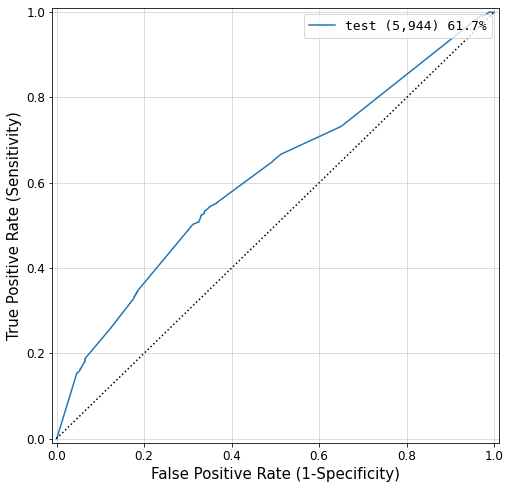

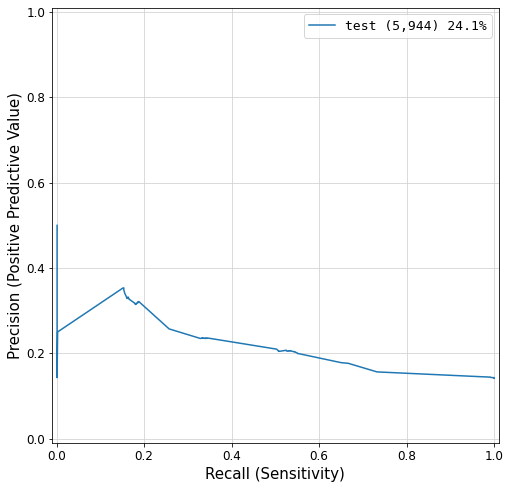

In [39]:
blm.plot_roc()